In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost


In [ ]:
!pip install --upgrade xgboost scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


Mounted at /content/drive
🚀 Starting Credit Card Fraud Detection...
📂 Loading data from Google Drive...
✅ Data loaded successfully!

📊 Train Data Shape: (1296675, 23)
📊 Test Data Shape: (555719, 23)

🔍 Train Data Columns: ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']

🎯 Target Variable Distribution:
is_fraud
0    1289169
1       7506
Name: count, dtype: int64
Percentage: is_fraud
0    99.421135
1     0.578865
Name: proportion, dtype: float64
🔧 Preprocessing data...
✅ Preprocessing complete!
Final train data shape: (1296675, 21), dtypes: float64    21
Name: count, dtype: int64
🤖 Training XGBoost model...
✅ Model trained successfully!

🌟 Top 10 Important Features:
       Feature  Importance
15        hour    0.363621
2     category    0.256935
3          amt    0.152886
4       gender    0

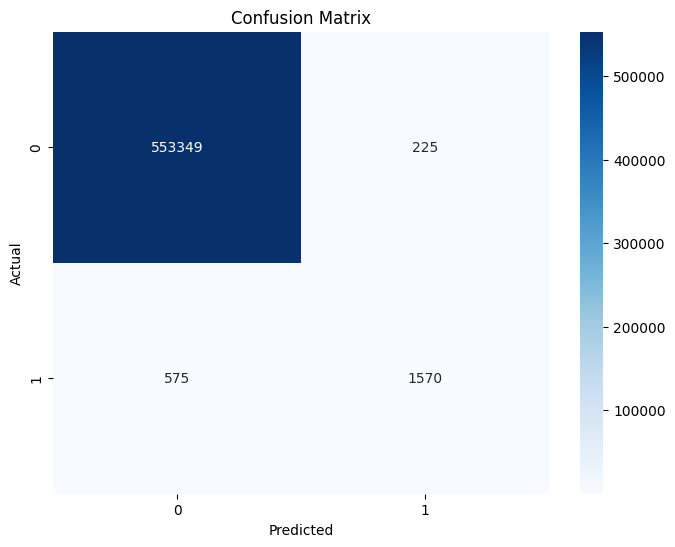


📈 Classification Report:
              precision    recall  f1-score       support
0.0            0.998962  0.999594  0.999278  553574.00000
1.0            0.874652  0.731935  0.796954    2145.00000
accuracy       0.998560  0.998560  0.998560       0.99856
macro avg      0.936807  0.865764  0.898116  555719.00000
weighted avg   0.998482  0.998560  0.998497  555719.00000

🔑 Key Metrics:
Accuracy: 0.9986
Precision: 0.8747
Recall: 0.7319
F1-Score: 0.7970

✨ Analysis complete! Your fraud detection model is ready.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample  # For balancing data (if needed)
from google.colab import drive  # For Google Drive integration
import time
import os

# Mount Google Drive
drive.mount('/content/drive')

# Paths to your data files
train_path = '/content/drive/MyDrive/Colab Notebooks/archive (3)/fraudTrain.csv'  # ← UPDATE THIS
test_path = '/content/drive/MyDrive/Colab Notebooks/archive (3)/fraudTest.csv'    # ← UPDATE THIS

# Function to load data from Google Drive
def load_data_from_drive(train_path, test_path):
    print("📂 Loading data from Google Drive...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    print("✅ Data loaded successfully!")
    return train_data, test_data

def preprocess_data(train_data, test_data):
    print("🔧 Preprocessing data...")

    # Get lists of different column types
    categorical_cols = ['merchant', 'category', 'gender', 'city', 'state', 'job']
    datetime_cols = ['trans_date_trans_time', 'dob']
    drop_cols = []  # Columns to eventually drop (like identifiers)

    # Process datetime columns
    try:
        # Transaction datetime
        train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])
        test_data['trans_date_trans_time'] = pd.to_datetime(test_data['trans_date_trans_time'])

        train_data['hour'] = train_data['trans_date_trans_time'].dt.hour
        train_data['day'] = train_data['trans_date_trans_time'].dt.day
        train_data['month'] = train_data['trans_date_trans_time'].dt.month
        train_data['dayofweek'] = train_data['trans_date_trans_time'].dt.dayofweek

        test_data['hour'] = test_data['trans_date_trans_time'].dt.hour
        test_data['day'] = test_data['trans_date_trans_time'].dt.day
        test_data['month'] = test_data['trans_date_trans_time'].dt.month
        test_data['dayofweek'] = test_data['trans_date_trans_time'].dt.dayofweek

        # Date of birth
        train_data['dob'] = pd.to_datetime(train_data['dob'])
        test_data['dob'] = pd.to_datetime(test_data['dob'])

        # Calculate age
        reference_date = pd.to_datetime('2023-01-01')  # Use a reference date
        train_data['age'] = (reference_date - train_data['dob']).dt.days / 365.25
        test_data['age'] = (reference_date - test_data['dob']).dt.days / 365.25

        # Drop original datetime columns
        drop_cols.extend(datetime_cols)
    except Exception as e:
        print(f"Error processing datetime columns: {e}")

    # Drop unnecessary columns that might cause issues (like identifiers)
    possible_drop_cols = ['cc_num', 'first', 'last', 'street', 'trans_num']
    for col in possible_drop_cols:
        if col in train_data.columns:
            drop_cols.append(col)

    # Handle categorical columns
    label_encoders = {}

    for col in categorical_cols:
        if col in train_data.columns:
            try:
                # Combine train and test values to get all possible categories
                all_values = set(train_data[col].astype(str).unique())
                all_values.update(test_data[col].astype(str).unique())

                # Create a mapping dictionary for encoding
                unique_values = list(all_values)
                mapping_dict = {val: idx for idx, val in enumerate(unique_values)}

                # Apply mapping to both datasets
                train_data[col] = train_data[col].astype(str).map(mapping_dict)
                test_data[col] = test_data[col].astype(str).map(mapping_dict)

                # Make sure they're numeric
                train_data[col] = train_data[col].astype(float)
                test_data[col] = test_data[col].astype(float)

                # Store the mapping for later use
                label_encoders[col] = mapping_dict
            except Exception as e:
                print(f"Error encoding column {col}: {e}")
                # If encoding fails, drop the column
                drop_cols.append(col)

    # Drop identified columns
    for col in drop_cols:
        if col in train_data.columns:
            train_data = train_data.drop(col, axis=1)
        if col in test_data.columns:
            test_data = test_data.drop(col, axis=1)

    # Handle missing values for remaining columns
    numeric_cols = train_data.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        imputer = SimpleImputer(strategy='mean')
        train_data[numeric_cols] = imputer.fit_transform(train_data[numeric_cols])
        test_data[numeric_cols] = imputer.transform(test_data[numeric_cols])

    # Check for any remaining object columns and convert them
    for col in train_data.select_dtypes(include=['object']).columns:
        print(f"Converting remaining object column: {col}")
        le = LabelEncoder()
        train_data[col] = le.fit_transform(train_data[col].astype(str))
        test_data[col] = le.transform(test_data[col].astype(str))
        label_encoders[col] = le

    print("✅ Preprocessing complete!")
    print(f"Final train data shape: {train_data.shape}, dtypes: {train_data.dtypes.value_counts()}")
    return train_data, test_data, label_encoders

def train_xgboost(X_train, y_train):
    print("🤖 Training XGBoost model...")

    # Ensure all columns are float type
    X_train = X_train.astype(float)

    # Configure XGBoost - CHANGED: Removed GPU-specific settings
    model = XGBClassifier(
        n_estimators=20,  # Using 20 estimators as requested
        max_depth=6,
        learning_rate=0.1,
        objective='binary:logistic',
        random_state=42,
        eval_metric='logloss',
        tree_method='hist',  # Using CPU-based histogram method
        enable_categorical=True  # Enable categorical features handling
    )

    # Train model
    model.fit(X_train, y_train)
    print("✅ Model trained successfully!")

    # Get feature importance
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("\n🌟 Top 10 Important Features:")
    print(importance_df.head(10))

    return model

def evaluate_model(model, X_test, y_test):
    print("📊 Evaluating model...")

    # Ensure test data is float type
    X_test = X_test.astype(float)

    # Make predictions
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report (Precision, Recall, F1, Support)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("\n📈 Classification Report:")
    print(report_df)

    # Key Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n🔑 Key Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return report_df

def predict_new_data(model, file_path, label_encoders):
    print(f"🔮 Predicting on new data: {file_path}...")

    # Load new data
    new_data = pd.read_csv(file_path)

    # Create a copy to avoid modifying the original
    processed_data = new_data.copy()

    # Process categorical columns
    for col, mapping in label_encoders.items():
        if col in processed_data.columns:
            if isinstance(mapping, dict):
                # Handle dictionary mappings
                processed_data[col] = processed_data[col].astype(str).map(lambda x: mapping.get(x, -1))
            else:
                # Handle LabelEncoder objects
                try:
                    processed_data[col] = mapping.transform(processed_data[col].astype(str))
                except:
                    # If transformation fails, assign a default value
                    processed_data[col] = -1

    # Process datetime columns if they exist
    datetime_cols = ['trans_date_trans_time', 'dob']
    try:
        if 'trans_date_trans_time' in processed_data.columns:
            processed_data['trans_date_trans_time'] = pd.to_datetime(processed_data['trans_date_trans_time'])
            processed_data['hour'] = processed_data['trans_date_trans_time'].dt.hour
            processed_data['day'] = processed_data['trans_date_trans_time'].dt.day
            processed_data['month'] = processed_data['trans_date_trans_time'].dt.month
            processed_data['dayofweek'] = processed_data['trans_date_trans_time'].dt.dayofweek
            processed_data.drop('trans_date_trans_time', axis=1, inplace=True)

        if 'dob' in processed_data.columns:
            processed_data['dob'] = pd.to_datetime(processed_data['dob'])
            reference_date = pd.to_datetime('2023-01-01')
            processed_data['age'] = (reference_date - processed_data['dob']).dt.days / 365.25
            processed_data.drop('dob', axis=1, inplace=True)
    except Exception as e:
        print(f"Error processing datetime columns in new data: {e}")

    # Drop identifier columns
    id_cols = ['cc_num', 'first', 'last', 'street', 'trans_num']
    for col in id_cols:
        if col in processed_data.columns:
            processed_data.drop(col, axis=1, inplace=True)

    # Ensure all columns are float
    for col in processed_data.columns:
        processed_data[col] = pd.to_numeric(processed_data[col], errors='coerce')

    # Handle any missing values
    processed_data = processed_data.fillna(0)

    # Make predictions
    try:
        X_pred = processed_data.drop('is_fraud', axis=1, errors='ignore')
        predictions = model.predict(X_pred)
        proba = model.predict_proba(X_pred)[:, 1]  # Fraud probability
    except Exception as e:
        print(f"Error during prediction: {e}")
        # Try matching columns with model
        model_features = model.feature_names_in_
        print(f"Model expects these features: {model_features}")
        print(f"New data has these features: {X_pred.columns.tolist()}")

        # Create DataFrame with only model features
        X_pred_matched = pd.DataFrame(0, index=np.arange(len(X_pred)), columns=model_features)
        for col in model_features:
            if col in X_pred.columns:
                X_pred_matched[col] = X_pred[col]

        predictions = model.predict(X_pred_matched)
        proba = model.predict_proba(X_pred_matched)[:, 1]

    # Add predictions to original data
    new_data['is_fraud_predicted'] = predictions
    new_data['fraud_probability'] = proba

    # Save results
    output_path = file_path.replace('.csv', '_predictions.csv')
    new_data.to_csv(output_path, index=False)
    print(f"💾 Predictions saved to: {output_path}")

    return new_data

# Main execution
if __name__ == '__main__':
    try:
        print("🚀 Starting Credit Card Fraud Detection...")

        # Load data
        train_data, test_data = load_data_from_drive(train_path, test_path)

        # Display basic information
        print(f"\n📊 Train Data Shape: {train_data.shape}")
        print(f"📊 Test Data Shape: {test_data.shape}")
        print(f"\n🔍 Train Data Columns: {train_data.columns.tolist()}")

        # Check for the target variable
        target_col = 'is_fraud'
        if target_col in train_data.columns:
            print(f"\n🎯 Target Variable Distribution:")
            print(train_data[target_col].value_counts())
            print(f"Percentage: {train_data[target_col].value_counts(normalize=True) * 100}")
        else:
            print(f"\n❌ Error: Target variable '{target_col}' not found in training data")
            raise ValueError(f"Target column '{target_col}' not found")

        # Preprocess data
        train_data, test_data, label_encoders = preprocess_data(train_data, test_data)

        # Define features and target
        X_train = train_data.drop(target_col, axis=1)
        y_train = train_data[target_col]

        X_test = test_data.drop(target_col, axis=1)
        y_test = test_data[target_col]

        # Train model
        model = train_xgboost(X_train, y_train)

        # Evaluate model
        evaluate_model(model, X_test, y_test)

        print("\n✨ Analysis complete! Your fraud detection model is ready.")

        # Uncomment the following to predict on new data
        # new_data_path = '/content/drive/MyDrive/Colab Notebooks/archive (3)/new_transactions.csv'
        # predictions = predict_new_data(model, new_data_path, label_encoders)

    except Exception as e:
        print(f"\n❌ Error occurred: {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
import pickle
import os

# Define the path where you want to save the model
model_save_path = '/content/drive/MyDrive/Colab Notebooks/fraud_detection_model.pkl'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Create a dictionary with model and encoders
model_package = {
    'model': model,
    'label_encoders': label_encoders
}

# Save using pickle
print(f"💾 Saving model to Google Drive at: {model_save_path}")
with open(model_save_path, 'wb') as file:
    pickle.dump(model_package, file)

print("✅ Model saved successfully!")

💾 Saving model to Google Drive at: /content/drive/MyDrive/Colab Notebooks/fraud_detection_model.pkl
✅ Model saved successfully!
